In [ ]:
# Import necessary libraries
import numpy as np  # Fundamental package for numerical computations
from keras.datasets import mnist  # MNIST dataset for digit recognition
from sklearn.mixture import GaussianMixture  # Gaussian Mixture Model for clustering
from skimage.util import view_as_windows  # Utility for extracting sliding windows from images
from joblib import Parallel, delayed  # Tools for parallel computing to speed up processing
import os  # Module for interacting with the operating system
import zipfile  # Module for reading and writing ZIP files
from PIL import Image  # Python Imaging Library for image processing
from sklearn.model_selection import KFold  # K-fold cross-validation for model evaluation
from scipy.stats import norm  # Statistical functions for normal distributions
from scipy.stats import multivariate_normal  # Multivariate normal distribution functions
from tqdm import tqdm  # Progress bar for loops and computations
import random  # Module for generating random numbers
from matplotlib import pyplot as plt  # Library for creating visualizations and plots

In [2]:
def extract_patches(image, m):
    """
    Extract patches from a given image using the efficient view_as_windows method.
    
    Parameters:
    image (ndarray): 2D array representing the image from which patches are extracted.
    m (int): The size of the square patch (m x m).

    Returns:
    patches_reshaped (ndarray): Flattened array of patches extracted from the image.
    """
    # Use view_as_windows to extract patches of size m x m
    patches_view = view_as_windows(image, (m, m))
    # Reshape the patches into a 2D array where each row is a flattened patch
    patches_reshaped = patches_view.reshape(-1, m ** 2)
    return patches_reshaped

def process_patches(saved=False, num_images=1000, num_components=30, patch_size=8, n_jobs=-1):
    """
    Process MNIST dataset to extract image patches and fit a Gaussian Mixture Model (GMM).
    
    Parameters:
    saved (bool): If True, load a pre-trained GMM model from disk. If False, train a new one.
    num_images (int): Number of images to sample from the dataset.
    num_components (int): Number of components for the Gaussian Mixture Model (GMM).
    patch_size (int): Size of the square patches to extract from each image.
    n_jobs (int): Number of jobs to run in parallel (-1 uses all available CPUs).

    Returns:
    gmm (GaussianMixture): Fitted GMM model for the extracted patches.
    """
    # Path where the GMM model parameters might be saved
    save_path = f'/kaggle/input/gmm-m{patch_size}-k{num_components}-n{num_images}/GMM M{patch_size} K{num_components} N{num_images}.npz'
    
    # Check if a saved GMM model exists and load it if the 'saved' flag is True
    if saved and os.path.exists(save_path):
        data = np.load(save_path)
        gmm_weights = data['gmm_weights']
        gmm_means = data['gmm_means']
        gmm_covariances = data['gmm_covariances']
        # Initialize a new GMM model and load its saved parameters
        gmm = GaussianMixture(n_components=num_components, max_iter=100)
        gmm.weights_ = gmm_weights
        gmm.means_ = gmm_means
        gmm.covariances_ = gmm_covariances
        print("Loaded saved GMM model.")
        return gmm

    # Load MNIST dataset from pre-downloaded .npz file
    mnist_data = np.load('/kaggle/input/mnist-full/mnist.npz')
    train_X = mnist_data['x_train']
    train_y = mnist_data['y_train']

    # We want to sample images equally across all 10 classes in the dataset
    num_classes = 10
    images_per_class = num_images // num_classes  # Distribute images evenly across classes

    # Randomly sample images from each class
    sampled_images = []
    for class_label in range(num_classes):
        class_images = train_X[train_y == class_label]  # Get images of the current class
        np.random.shuffle(class_images)  # Shuffle the images for randomness
        sampled_images.append(class_images[:images_per_class])  # Select the first N images

    # Concatenate all sampled images into a single array
    sampled_images = np.concatenate(sampled_images, axis=0)

    # Set parameters for patch extraction
    m = patch_size
    image_size = sampled_images[0].shape[1]  # Assuming square images
    patches_per_image = (image_size - m + 1) ** 2  # Calculate number of patches per image

    # Extract patches from all sampled images in parallel
    patches_list = Parallel(n_jobs=n_jobs)(
        delayed(extract_patches)(sampled_images[i], m) for i in range(len(sampled_images))
    )

    # Combine all extracted patches into a single array
    patches = np.vstack(patches_list)

    # Fit a Gaussian Mixture Model (GMM) to the extracted patches
    gmm = GaussianMixture(n_components=num_components, max_iter=100)
    gmm.fit(patches)

    # Save the GMM model parameters and patches to a file
    np.savez(f'GMM, M={patch_size}, K={num_components}, N={num_images}.npz',
             gmm_weights=gmm.weights_,
             gmm_means=gmm.means_,
             gmm_covariances=gmm.covariances_)

    print(f"Generated patches from {num_images} images (uniform per class, with randomness) and fitted GMM model.")
    return gmm

In [3]:
# Define the desired image size for resizing
image_size = (28, 28)

def get_image_filenames(zip_file, folder):
    """
    Retrieve a list of image filenames from a specific folder within a zip file.
    
    Parameters:
    zip_file (ZipFile): Opened zip file object.
    folder (str): The folder path inside the zip file where images are located.
    
    Returns:
    list: Filenames of images in the specified folder.
    """
    # Filter image names that belong to the specified folder and have a '.png' extension
    return [name for name in zip_file.namelist() if name.startswith(f'MNIST{folder}') and name.endswith('.png')]

def load_images_from_zip(folder_path, original_folder, corrupted_folder):
    """
    Load both original and corrupted images from specified folders and return them as numpy arrays.
    
    Parameters:
    folder_path (str): Path to the directory containing the folders of images.
    original_folder (str): Folder name for original images.
    corrupted_folder (str): Folder name for corrupted images.

    Returns:
    np.ndarray: Array containing original images loaded and resized.
    np.ndarray: Array containing corrupted images loaded and resized.
    """
    # Get a list of image filenames for both original and corrupted images in their respective folders
    original_filenames = [f for f in os.listdir(folder_path + original_folder) if f.endswith(('png', 'jpg', 'jpeg'))]
    corrupted_filenames = [f for f in os.listdir(folder_path + corrupted_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

    # Find the common filenames between the original and corrupted images by comparing filenames only (ignoring path)
    common_filenames = set(os.path.basename(fname) for fname in original_filenames) & \
                       set(os.path.basename(fname) for fname in corrupted_filenames)

    # Initialize lists to hold the image data for both original and corrupted images
    original_images = []
    corrupted_images = []

    # Loop through each common filename, load both the original and corrupted image, and resize them
    for image_file in common_filenames:
        # Load and resize the original image, then convert it to a numpy array
        original_image_path = folder_path + original_folder + "/" + image_file
        original_image = Image.open(original_image_path).convert('L').resize(image_size)
        original_images.append(np.array(original_image))

        # Load and resize the corrupted image, then convert it to a numpy array
        corrupted_image_path = folder_path + corrupted_folder + "/" + image_file
        corrupted_image = Image.open(corrupted_image_path).convert('L').resize(image_size)
        corrupted_images.append(np.array(corrupted_image))

    # Convert the lists of original and corrupted images to numpy arrays
    original_images = np.array(original_images)
    corrupted_images = np.array(corrupted_images)

    # Print the number of images successfully loaded from both categories
    print(f"Loaded {len(original_images)} original and {len(corrupted_images)} corrupted images.")

    return original_images, corrupted_images

In [4]:
def patchExtractor(x, m, name):
    """
    Extract patches from a batch of images and reshape them for further processing.

    Parameters:
    x (np.ndarray): Input batch of images. Shape is expected to be (num_images, height, width).
    m (int): Size of the patches to extract (m x m).
    name (str): Name label used for printing, indicating the type of patches being extracted.

    Returns:
    np.ndarray: Array of flattened patches with shape (num_patches, m^2).
    """
    
    # Assume x is a batch of square images; extract the image dimensions
    image_size = x.shape[1]  # Height (and width) of each image
    num_images = x.shape[0]  # Number of images in the batch

    # Calculate the number of patches to extract from each image
    patches_per_image = (image_size - m + 1) ** 2

    # Efficiently create patches by sliding a window of size (m x m) over the images
    # Use strides to access the images in overlapping blocks without copying data
    strides = x.strides + x.strides[1:3]  # Adjust strides to create m x m blocks

    # Generate patches using np.lib.stride_tricks.as_strided to create a view of the image array
    patches_view = np.lib.stride_tricks.as_strided(
        x,
        shape=(num_images, image_size - m + 1, image_size - m + 1, m, m),  # Shape of the patches view
        strides=strides  # Stride configuration for overlapping patches
    )

    # Reshape the patches into a 2D array where each row is a flattened patch
    patches = patches_view.reshape(num_images * patches_per_image, m ** 2)

    # Print the name and number of patches extracted for debugging or logging purposes
    print(f"Extracted {name} patches, for m = {m}.")

    return patches

In [5]:
def find_best_sigma(k, sigmas, W, m, original_patches, corrupted_patches):
    """
    Find the best sigma^2 value using k-fold cross-validation to minimize the negative log likelihood.

    Parameters:
    - k (int): Number of folds for cross-validation.
    - sigmas (array): Array of potential sigma^2 values to evaluate.
    - W (ndarray): Weight matrix loaded from the .npy file, used for predicting the corrupted patches.
    - m (int): Number of patches.
    - original_patches (ndarray): Array of patches from the original (clean) data.
    - corrupted_patches (ndarray): Array of patches from the corrupted data.

    Returns:
    - sigma_best (float): The sigma^2 value that minimizes the negative log likelihood.
    """

    # Initialize an array to store mean squared error (MSE) values for each sigma^2 candidate.
    mse = np.zeros(len(sigmas))

    # Create a k-fold cross-validation object to split the data into k parts.
    kf = KFold(n_splits=k)

    # Precompute the k-fold splits to avoid recalculating them for each sigma.
    kf_indices = list(kf.split(original_patches))

    # Loop through each possible sigma^2 value to evaluate its performance.
    for i, sigma in enumerate(sigmas):
        # Initialize an array to store squared error for each cross-validation fold.
        se = np.zeros(k)

        # Loop through each fold to perform cross-validation.
        for j, (train_idx, test_idx) in enumerate(kf_indices):
            # Use test indices to extract test data from original and corrupted patches.
            Z_test = original_patches[test_idx]  # Test set from original (clean) patches
            Y_test = corrupted_patches[test_idx]  # Corresponding corrupted patches

            # Predict the corrupted patches using the weight matrix W.
            Y_pred = np.dot(Z_test, W.T)

            # Compute the probability density of the prediction errors using the normal distribution.
            # 'p' is the probability of the prediction error (Y_pred - Y_test) being close to zero with variance sigma^2.
            p = norm.pdf(Y_pred - Y_test, loc=0, scale=sigma)

            # Calculate the negative log likelihood (mean negative log of probabilities) for this fold.
            # Small epsilon (1e-10) is added to avoid taking log(0), which would result in infinity.
            se[j] = -np.mean(np.log(p + 1e-10))

        # After evaluating all folds for this sigma^2, store the average squared error (SE) in the MSE array.
        mse[i] = np.mean(se)

    # Identify the sigma^2 value that resulted in the minimum mean squared error.
    idx = np.argmin(mse)

    # Return the best-performing sigma^2 value.
    sigma_best = sigmas[idx]

    return sigma_best

In [6]:
def denoise_images(original_images, corrupted_patches, W, sigma_best, gmm, num_components, num=45, m=8):
    """
    Denoise corrupted patches using a Gaussian Mixture Model (GMM).

    Parameters:
    - original_images: Array of original clean images.
    - corrupted_patches: Array of corrupted image patches to denoise.
    - W: Weight matrix used for denoising.
    - sigma_best: Best sigma value obtained through optimization.
    - gmm: Fitted Gaussian Mixture Model (GMM) for image data.
    - num_components: Number of components in the GMM.
    - num: Number of images to denoise (default is 45).
    - m: Patch size (default is 8x8 patches).

    Returns:
    - denoised_images1: The denoised images as reconstructed using the denoised patches.
    """
    
    l = 28 - m + 1  # Size adjustment to match patch structure
    cor2 = corrupted_patches[:l**2 * num]  # Extract relevant corrupted patches based on the number of images

    # Initialize array to store the denoised patches
    denoised_patches = np.zeros_like(cor2)

    # Precompute constant matrices for the denoising process
    temp_A = W.T @ W / sigma_best**2  # Precompute part of the matrix operation involving W and sigma
    B = W / sigma_best**2  # Weight matrix adjusted by sigma
    T_B = B.T  # Transpose of the adjusted weight matrix for use in later operations

    # Initialize matrices to store intermediate calculations for each GMM component
    Sigmas = np.zeros_like(gmm.covariances_)  # Store the covariance matrices of the GMM components
    As = np.zeros_like(gmm.covariances_)  # Store the combined covariance matrices for each component
    Inv_As = np.zeros_like(gmm.covariances_)  # Store the inverse of As for each component
    A_dets = np.zeros(gmm.n_components)  # Store the determinants of the As matrices
    Sigma_dets = np.zeros(gmm.n_components)  # Store the determinants of the original covariance matrices

    # Precompute GMM-related values for each component
    for k in range(gmm.n_components):
        Sigmas[k] = gmm.covariances_[k]  # Extract the covariance matrix for component k
        As[k] = np.linalg.inv(Sigmas[k]) + temp_A  # Compute the adjusted covariance matrix As
        Inv_As[k] = np.linalg.inv(As[k])  # Inverse of As for later use
        Inv_As[k] = 0.5 * (Inv_As[k] + Inv_As[k].T)  # Symmetrize Inv_As to avoid numerical instability
        A_dets[k] = np.linalg.det(As[k])  # Compute determinant of As
        Sigma_dets[k] = np.linalg.det(Sigmas[k])  # Compute determinant of the original covariance matrix

    # Initialize arrays for the GMM component means and posterior probabilities
    Mus = np.zeros_like(gmm.means_)  # Array to store updated means for each component
    posterior_probs = np.zeros(gmm.n_components)  # Array to store posterior probabilities for each component

    # Loop through all corrupted patches to denoise them
    for i in tqdm(range(len(cor2))):
        y = cor2[i]  # Extract current corrupted patch

        # For each GMM component, calculate the posterior probability and updated mean
        for k in range(gmm.n_components):
            Pi = gmm.weights_[k]  # Prior probability of component k
            Mu = gmm.means_[k]  # Mean vector of component k
            Sigma = gmm.covariances_[k]  # Covariance matrix of component k
            v_k = y - W @ Mu  # Residual vector between corrupted patch and the mean of component k

            # Calculate the updated mean (Mu) based on the weighted residual and component covariance
            Mus[k] = Inv_As[k] @ T_B @ v_k

            # Compute the posterior probability of component k for the current corrupted patch
            posterior_probs[k] = Pi / np.sqrt(A_dets[k] * Sigma_dets[k]) * \
                                 np.exp(-0.5 * v_k.T @ (np.eye(m ** 2) / sigma_best ** 2 - B @ Inv_As[k] @ B.T) @ v_k) * \
                                 multivariate_normal.pdf(Mu, mean=Inv_As[k] @ T_B @ v_k, cov=Inv_As[k], allow_singular=True)

        # Select the component with the highest posterior probability
        max_component = np.argmax(posterior_probs)

        # Estimate the denoised patch as the mean of the selected component
        denoised_patches[i] = Mus[max_component]

    # Reshape the denoised patches back to m × m size
    denoised_patches = denoised_patches.reshape((-1, m, m))

    # Initialize arrays to store the fully denoised images
    denoised_images1 = np.zeros((num, 28, 28), dtype=np.float64)  # First reconstruction method
    denoised_images2 = np.zeros((num, 28, 28), dtype=np.float64)  # Second reconstruction method
    count = np.zeros((28, 28))  # Patch overlap count for normalization

    # Precompute overlap normalization factors for image reconstruction
    for i in range(28):
        for j in range(28):
            count[i, j] = 1 / (min(min(i + 1, 28 - i), m) * min(min(j + 1, 28 - j), m))

    # Reconstruct the full images using the denoised patches
    for n in range(len(cor2)):
        image_number = n // (l ** 2)  # Identify which image the current patch belongs to
        col_number = n % l  # Identify the column of the current patch
        row_number = (n % (l ** 2)) // l  # Identify the row of the current patch

        # Accumulate the denoised patch into the reconstructed image
        denoised_images1[image_number, row_number:row_number + m, col_number:col_number + m] += denoised_patches[n]
        denoised_images2[image_number, row_number:row_number + m, col_number:col_number + m] += denoised_patches[n] * count[row_number:row_number + m, col_number:col_number + m]

    # Compute the mean squared error (MSE) between the denoised and original images
    mse1 = np.mean((original_images[:num] - denoised_images1) ** 2)
    mse2 = np.mean((original_images[:num] - denoised_images2) ** 2)

    # Print the results of the denoising process
    print(f"Denoised images for m = {m}.")
    print(f'MSE for constructed images with K = {num_components} and m = {m} is {min(mse1, mse2)}.')

    # Return the denoised images (using the reconstruction method with the lower MSE)
    return denoised_images1  # Return denoised_images1 or denoised_images2 based on lower MSE

In [7]:
def plot_images(denoised_images, original_images, corrupted_images):
    """
    Plot a comparison of denoised, original, and corrupted images.

    Parameters:
    - denoised_images: Array of images that have been denoised.
    - original_images: Array of the original, clean images.
    - corrupted_images: Array of images with corruption or noise.

    This function selects 5 random images and displays them in a figure with 3 columns:
    - Column 1: The denoised version of the image.
    - Column 2: The original version of the image.
    - Column 3: The corrupted version of the image.
    """
    
    num_images = 5  # Define the number of images to be displayed
    plt.figure(figsize=(12, num_images * 5))  # Set the figure size based on the number of images

    # Randomly sample indices from the set of denoised images
    indices = random.sample(range(len(denoised_images)), num_images)

    # Loop through the sampled indices and plot corresponding images
    for i, index in enumerate(indices):
        # Plot the denoised image in the first column
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(denoised_images[index], cmap='gray')
        plt.title('Denoised Image')

        # Plot the original image in the second column
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(original_images[index], cmap='gray')
        plt.title('Original Image')

        # Plot the corrupted image in the third column
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(corrupted_images[index], cmap='gray')
        plt.title('Corrupted Image')

        # Enable grid to improve visual alignment
        plt.grid(True)

    # Ensure that subplots fit within the figure area and do not overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [8]:
def denoise(saved, num_components, m, sigmas, num_images=1000):
    """
    Perform the denoising process using Gaussian Mixture Models (GMM) and cross-validation 
    to find the best noise standard deviation (sigma). This function loads images, extracts 
    patches, finds the best sigma, denoises the corrupted patches, and then displays the results.

    Parameters:
    - saved: Boolean indicating whether to save or reload the processed data.
    - num_components: Number of components for the Gaussian Mixture Model (GMM).
    - m: Size of the image patches to be extracted.
    - sigmas: List of potential sigma values for cross-validation.
    - num_images: Number of images to process (default: 1000).

    Returns:
    - denoised_images: Array of denoised images.
    - original_images: Array of the original, clean images.
    - corrupted_images: Array of the corrupted images.
    """
    
    # Train or load a GMM based on the image patches
    gmm = process_patches(saved=saved, num_images=num_images, num_components=num_components, patch_size=m, n_jobs=-1)

    # Load the original and corrupted images from a dataset (the dataset path is not required on Kaggle)
    original_images, corrupted_images = load_images_from_zip(
        f'/kaggle/input/ml-project-phase-2/Dataset/MNIST-m={m}/MNIST', 
        '/original', 
        '/corrupted'
    )

    # Extract patches from the original and corrupted images using patch size m
    original_patches = patchExtractor(original_images, m, "original")
    corrupted_patches = patchExtractor(corrupted_images, m, "corrupted")

    # Load the weight matrix W, which is required for the denoising process
    W = np.load(f"/kaggle/input/ml-project-phase-2/Dataset/MNIST-m={m}/MNIST/W.npy")

    # Find the best sigma using cross-validation with k-fold method (5 folds)
    best_sigma = find_best_sigma(5, sigmas, W, m, original_patches, corrupted_patches)
    print(f"Best value of noise std for m = {m}: ", best_sigma)

    # Denoise the corrupted patches using the best sigma value and GMM
    denoised_images = denoise_images(original_images, corrupted_patches, W, best_sigma, gmm, num_components, num=10, m=m)

    # Plot and compare denoised, original, and corrupted images
    plot_images(denoised_images, original_images, corrupted_images)

    return denoised_images, original_images, corrupted_images

Loaded saved GMM model.

Loaded 296 original and 296 corrupted images.

Extracted original patches, for m = 8.

Extracted corrupted patches, for m = 8.

Best value of noise std for m = 8:  65


  0%|          | 0/4410 [00:00<?, ?it/s]<ipython-input-6-483a35ee3f03>:65: RuntimeWarning: invalid value encountered in scalar multiply

  posterior_probs[k] = Pi / np.sqrt(A_dets[k] * Sigma_dets[k]) * np.exp(- 0.5 * v_k.T @ (np.eye(m ** 2) / sigma_best ** 2 - B @ Inv_As[k] @ B.T) @ v_k) * multivariate_normal.pdf(Mu, mean=Inv_As[k] @ T_B @ v_k, cov=Inv_As[k], allow_singular=True)

100%|██████████| 4410/4410 [04:14<00:00, 17.33it/s]


Denoised images for m = 8.

MSE for constructed images with K = 30 and m = 8 is 3865.5022959183675.


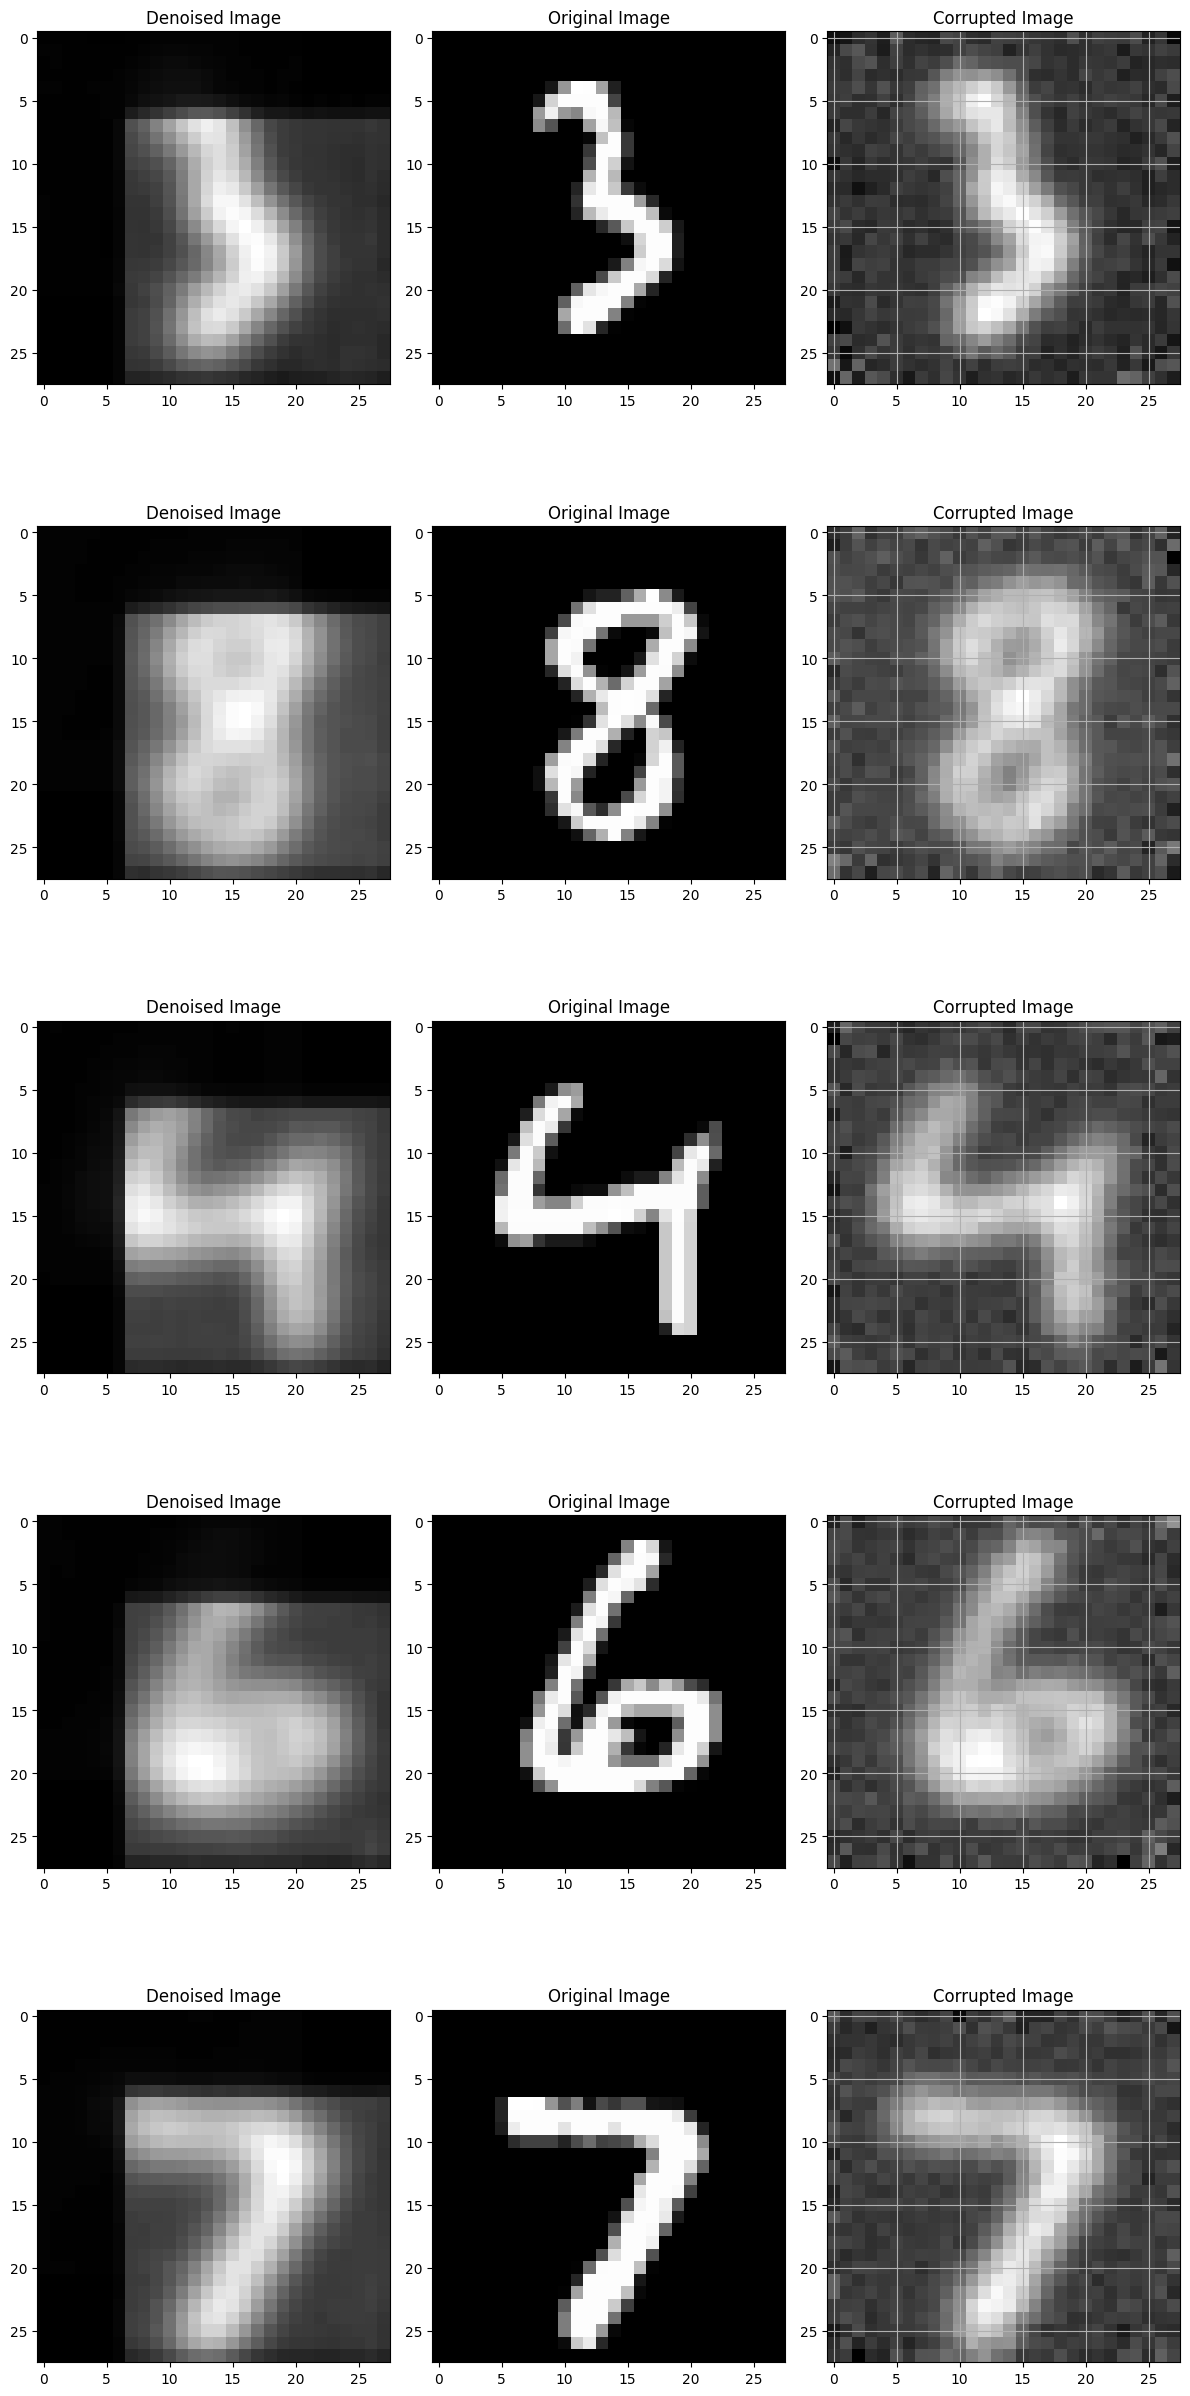

In [23]:
# Call the denoise function to denoise images using specified parameters
denoised_images, original_images, corrupted_images = denoise(
    saved=True,  # Indicates whether to load the pre-processed GMM data from storage
    num_components=30,  # Number of components for the Gaussian Mixture Model
    m=8,  # Size of the image patches to extract (8x8 pixels)
    sigmas=np.array([5, 10, 20, 30, 45, 65]),  # Array of possible noise standard deviation values to test
    num_images=10000  # Number of images to process for denoising
)

Loaded saved GMM model.

Loaded 278 original and 278 corrupted images.

Extracted original patches, for m = 4.

Extracted corrupted patches, for m = 4.

Best value of noise std for m = 4:  30


100%|██████████| 6250/6250 [00:38<00:00, 161.93it/s]


Denoised images for m = 4.

MSE for constructed images with K = 16 and m = 4 is 2600.5169253671525.


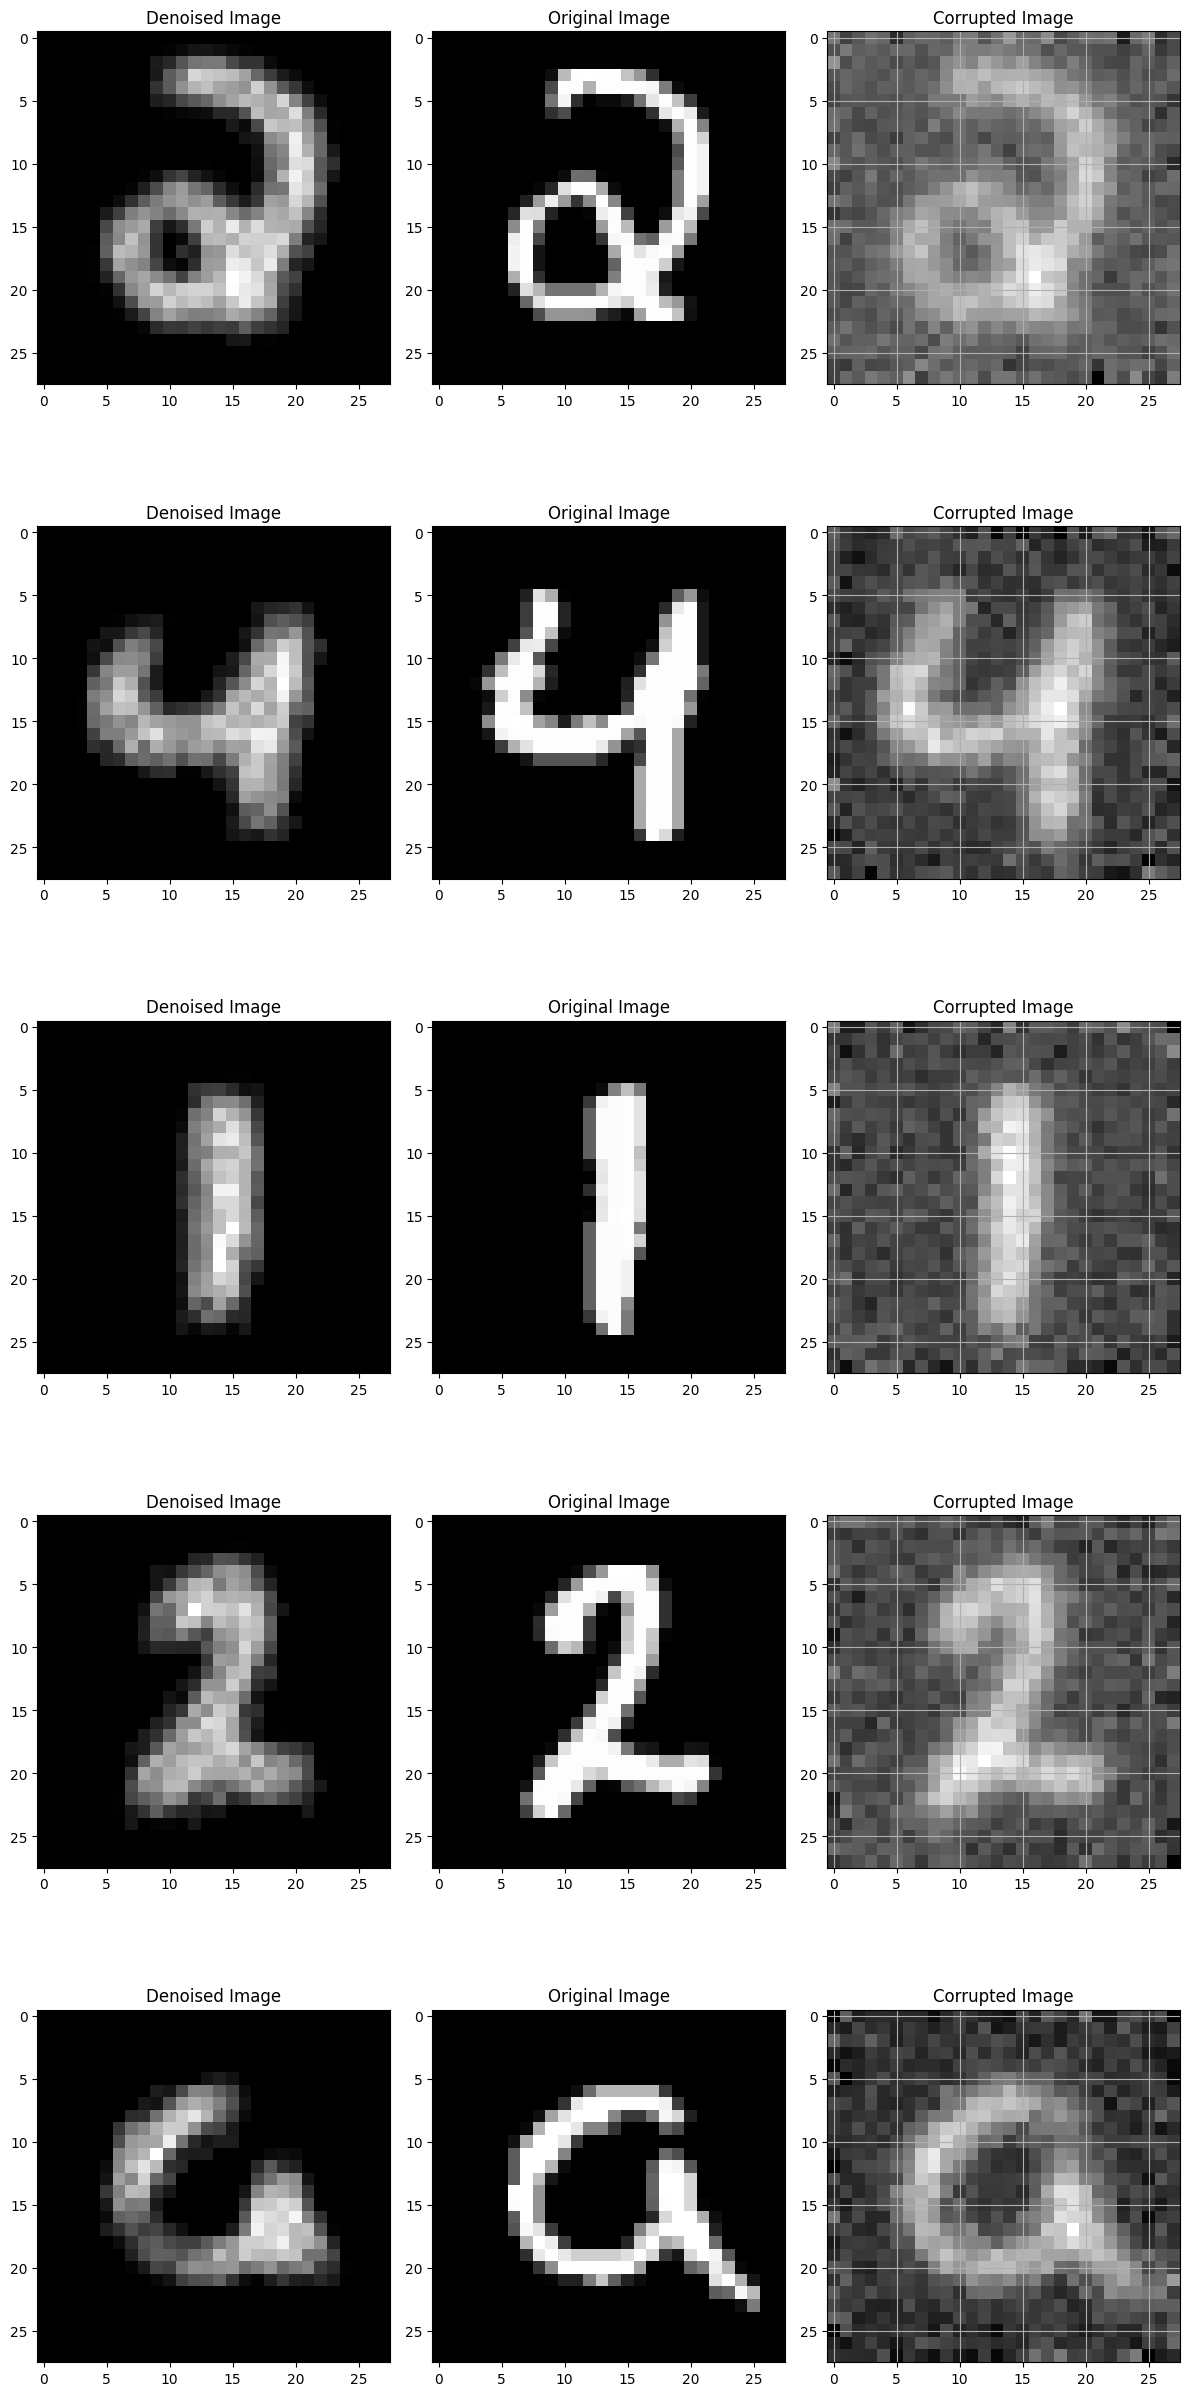

In [ ]:
# Call the denoise function to denoise images using specified parameters
denoised_images, original_images, corrupted_images = denoise(
    saved=True,  # Indicates whether to load the pre-processed GMM data from storage
    num_components=16,  # Number of components for the Gaussian Mixture Model
    m=4,  # Size of the image patches to extract (8x8 pixels)
    sigmas=np.array([5, 10, 15, 25, 30]),  # Array of possible noise standard deviation values to test
    num_images=10000  # Number of images to process for denoising
)

Loaded saved GMM model.
Loaded 296 original and 296 corrupted images.
Emxtracted original patches, for m = 12.
Emxtracted corrupted patches, for m = 12.


/opt/conda/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Best value of noise std for m = 12:  180


  0%|          | 0/2890 [00:00<?, ?it/s]/tmp/ipykernel_30/1994745461.py:65: RuntimeWarning: invalid value encountered in scalar multiply
  posterior_probs[k] = Pi / np.sqrt(A_dets[k] * Sigma_dets[k]) * np.exp(- 0.5 * v_k.T @ (np.eye(m ** 2) / sigma_best ** 2 - B @ Inv_As[k] @ B.T) @ v_k) * multivariate_normal.pdf(Mu, mean=Inv_As[k] @ T_B @ v_k, cov=Inv_As[k], allow_singular=True)
100%|██████████| 2890/2890 [26:26<00:00,  1.82it/s]


Denoised images for m = 12.
MSE for constructed images with K = 11 and m = 12 is 6166.920995353779.


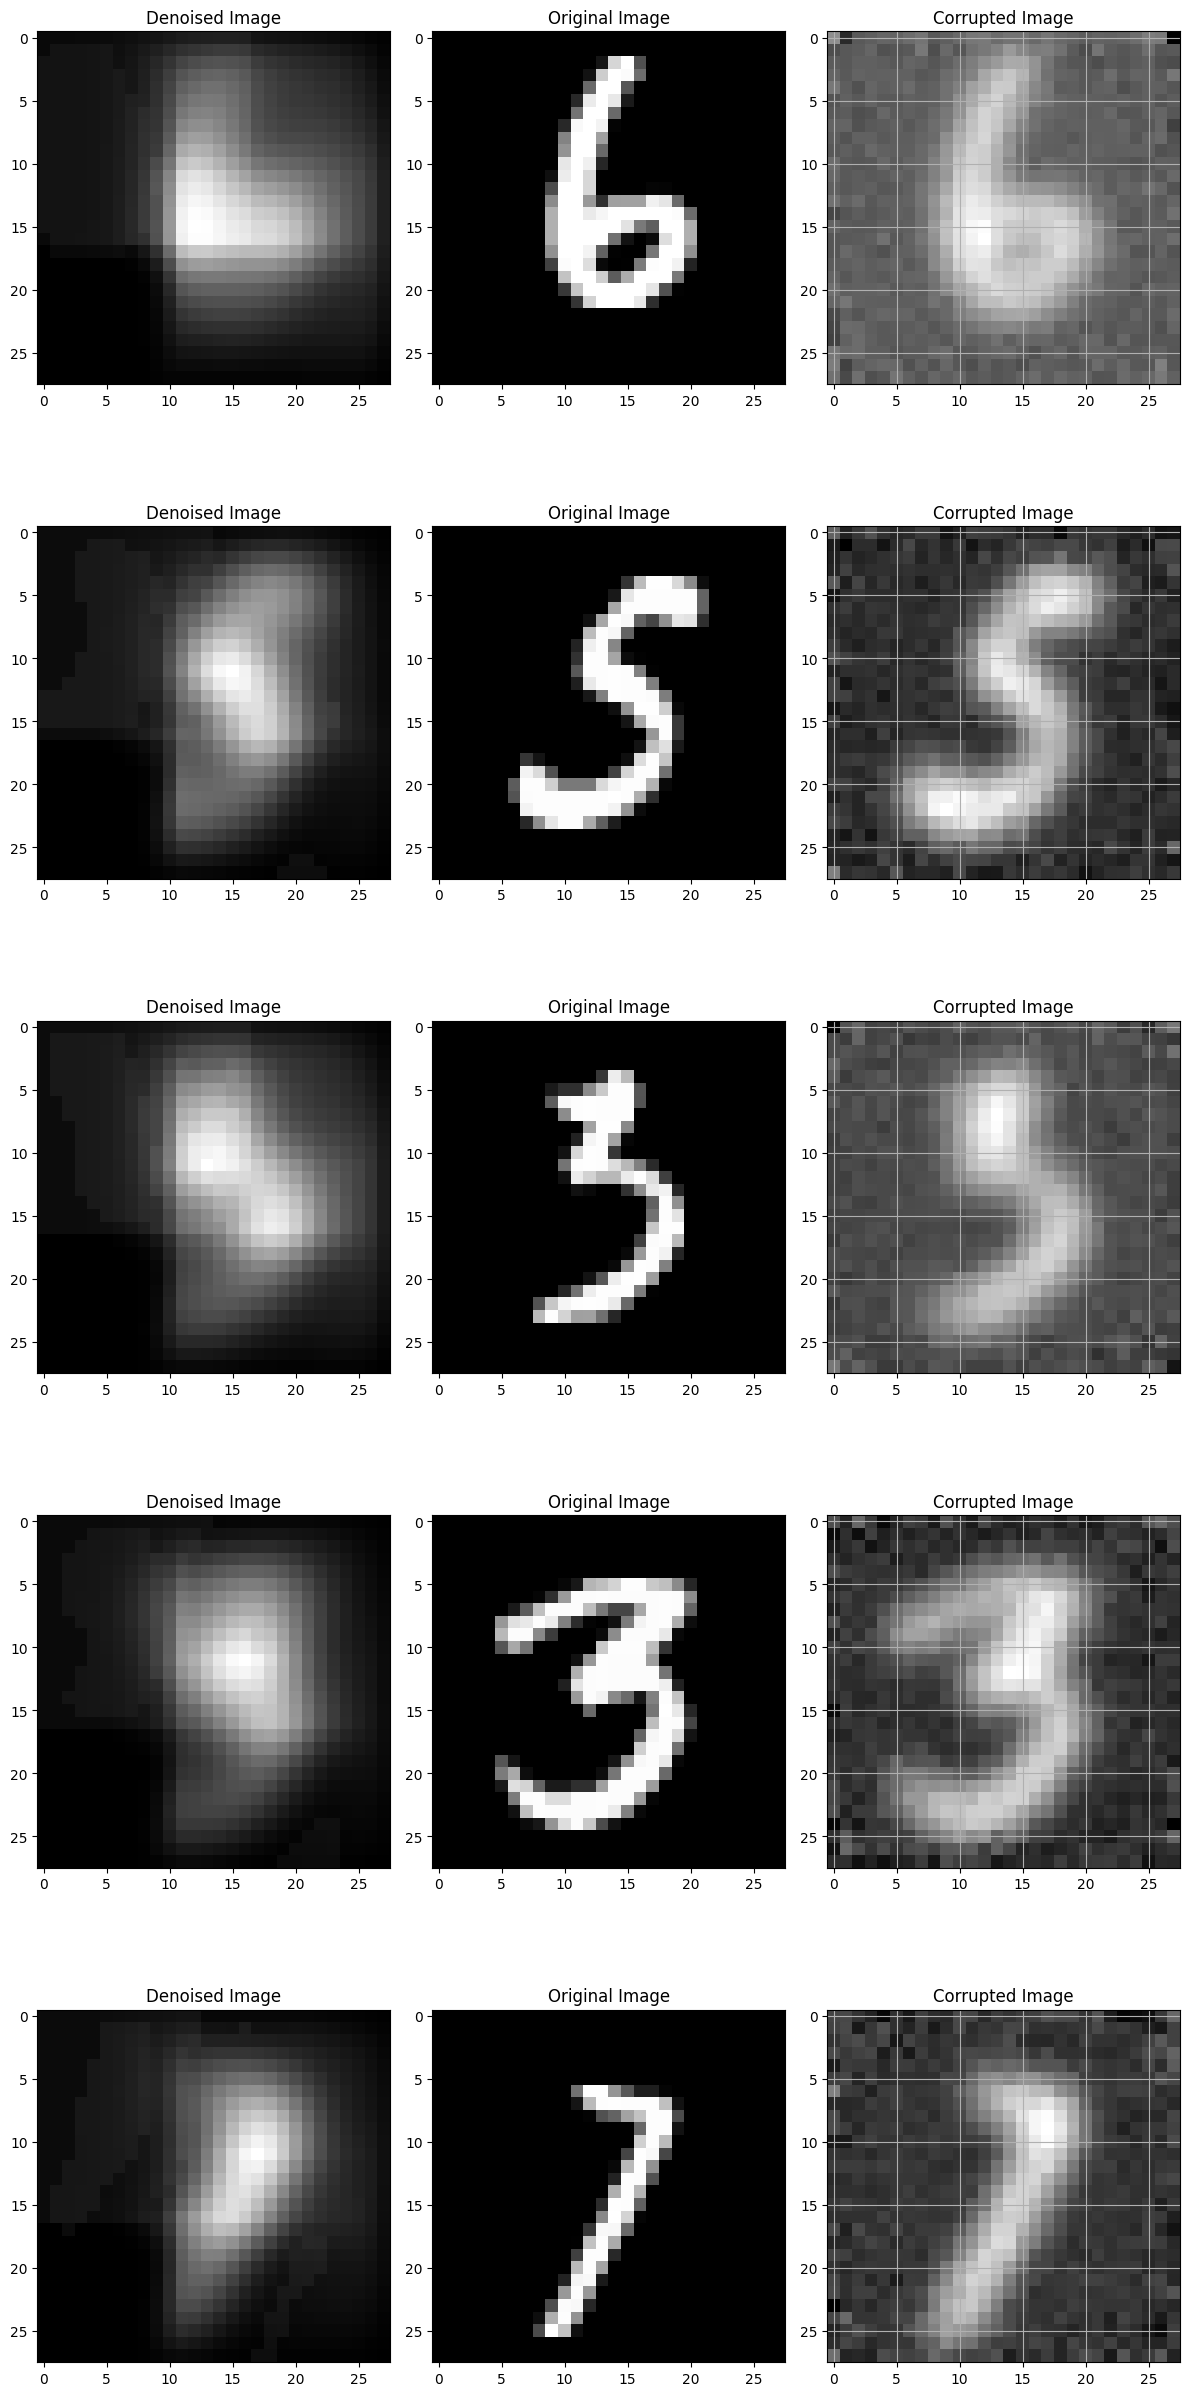

In [9]:
# Call the denoise function to denoise images using specified parameters
denoised_images, original_images, corrupted_images = denoise(
    saved=True,  # Indicates whether to load the pre-processed GMM data from storage
    num_components=11,  # Number of components for the Gaussian Mixture Model
    m=12,  # Size of the image patches to extract (8x8 pixels)
    sigmas=np.array([5, 10, 45, 180]),  # Array of possible noise standard deviation values to test
    num_images=10000  # Number of images to process for denoising
)